## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator

## fetch_mldata() is dead because it relied on a website that died. 
# -- https://github.com/ageron/handson-ml/issues/529
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KDTree

from sklearn.feature_extraction.text import CountVectorizer

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X.astype('float32'))
        if self.algorithm == 'brute':
            self.train = X.astype('float32')
        self.train_index = np.int16(y)
        self.classes_number = self.train_index.max() + 1
        return self
    
    def predict(self, X):
        if self.algorithm == 'kd_tree':
            distances, neighbors = self.tree.query(X.astype('float32'), k=self.n_neighbors)
        if self.algorithm == 'brute':
            distances = self.custom_l2_norm(X.astype('float32'))
            neighbors = np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]
        predicts = self.train_index[neighbors]
        result = np.apply_along_axis(
            lambda x: np.bincount(x, minlength=self.classes_number), axis=1, arr=predicts)
        return (result / self.n_neighbors).argmax(axis=1)
    
    def custom_l2_norm(self, X):
        train_squared_sum = np.ones([2, self.train.shape[0]], dtype='float32')
        test_squared_sum = np.ones([2, X.shape[0]], dtype='float32')
        if (str(type(self.train)) == "<class 'scipy.sparse.csr.csr_matrix'>" or 
            str(type(X)) == "<class 'scipy.sparse.csr.csr_matrix'>"):
            train_squared_sum[0] = np.flip((self.train.power(2)).sum(axis=1)).getA()[:, 0]
            test_squared_sum[1] = (X.astype('float32').power(2)).sum(axis=1).getA()[:, 0]  
        else: 
            train_squared_sum[0] = np.flip((self.train ** 2).sum(axis=1))
            test_squared_sum[1] = (X.astype('float32') ** 2).sum(axis=1)
        return (
            np.matmul(np.rot90(train_squared_sum), test_squared_sum) - 2 *
            (self.train.astype('float32') @ X.astype('float32').T)).T    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(n_neighbors=2)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [11]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


MyKNeighborsClassifier(n_neighbors=2)

In [12]:
%time clf.predict(X_test)

Wall time: 3 ms


array([2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 2, 1, 0, 1])

In [13]:
%time my_clf.predict(X_test)

Wall time: 2 ms


array([2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 2, 1, 0, 1], dtype=int64)

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

Wall time: 3 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [17]:
%time my_clf.fit(X_train, y_train)

Wall time: 990 µs


MyKNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [18]:
%time clf.predict(X_test)

Wall time: 5 ms


array([0, 1, 1, 2, 2, 0, 0, 1, 0, 2, 1, 0, 2, 2, 1])

In [19]:
%time my_clf.predict(X_test)

Wall time: 997 µs


array([0, 1, 1, 2, 2, 0, 0, 1, 0, 2, 1, 0, 2, 2, 1], dtype=int64)

In [20]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [21]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [22]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [24]:
cv = CountVectorizer(max_df=0.6)
word_count_vector = cv.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [25]:
from sklearn.model_selection import StratifiedKFold # больше не в sklearn.cross_validation

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [26]:
def validateKNN(k_max, data, target, n_splits=3):
    skf = StratifiedKFold(n_splits=n_splits)
    skf.get_n_splits(data, target)
    avg_score = []

    for k in range(1, k_max+1):
        sum_score = 0
        for train_index, test_index in skf.split(data, target):
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = target[train_index], target[test_index]
            
            my_clf = MyKNeighborsClassifier(n_neighbors=k, algorithm='brute')
            my_clf.fit(X_train, y_train)
            my_clf_pred = my_clf.predict(X_test)
            sum_score += accuracy_score(y_test, my_clf_pred)
        avg_score.append(sum_score / skf.n_splits)
    return avg_score

best k: 1 -> validation score: 0.22140708626483727


<AxesSubplot:>

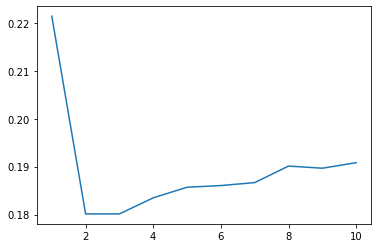

In [27]:
k_max=10
scores = validateKNN(k_max, word_count_vector, target)

print(f'best k: {np.argmax(scores) + 1} -> validation score: {np.max(scores)}')

sns.lineplot(y=scores, x=np.arange(1, k_max+1))

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

best k: 1 -> validation score: 0.1365567151745676


<AxesSubplot:>

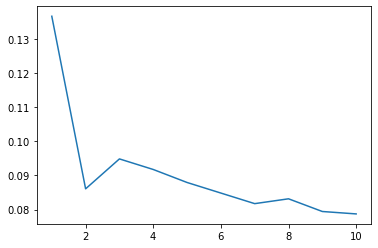

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)
tf_idf_vector = tfidf_transformer.transform(word_count_vector)

k_max=10
scores = validateKNN(k_max, tf_idf_vector, target)

print(f'best k: {np.argmax(scores) + 1} -> validation score: {np.max(scores)}')

sns.lineplot(y=scores, x=np.arange(1, k_max+1))

best k: 1 -> validation score: 0.19250491110978007


<AxesSubplot:>

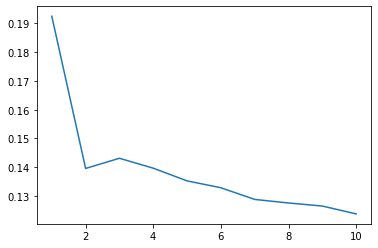

In [29]:
# cosine: 
from sklearn.preprocessing import normalize
word_count_vector_normalized = normalize(word_count_vector, norm='l2', axis=1)


k_max=10
scores = validateKNN(k_max, word_count_vector_normalized, target)

print(f'best k: {np.argmax(scores) + 1} -> validation score: {np.max(scores)}')

sns.lineplot(y=scores, x=np.arange(1, k_max+1))

best k: 1 -> validation score: 0.1365567151745676


<AxesSubplot:>

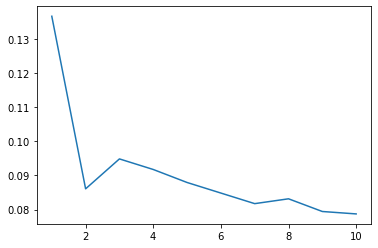

In [30]:
#tfidf + cosine
tf_idf_vector_normalized = normalize(tf_idf_vector, norm='l2', axis=1)

k_max=10
scores = validateKNN(k_max, tf_idf_vector_normalized, target)

print(f'best k: {np.argmax(scores) + 1} -> validation score: {np.max(scores)}')

sns.lineplot(y=scores, x=np.arange(1, k_max+1))

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [31]:
# k = 1; l2 norm, CountVectorize 
my_clf = MyKNeighborsClassifier(n_neighbors=1, algorithm='brute')
my_clf.fit(word_count_vector, target)

newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

data = newsgroups['data']
target = newsgroups['target']

word_count_vector_test = cv.transform(data)

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [33]:
my_clf_pred = my_clf.predict(word_count_vector_test)
accuracy_score(target, my_clf_pred)

0.1808284652150823

> Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

отличается, на тесте меньше. фичи слабые, k=1, т.е. от алгоритма в принципе какого-то толка нет: очень простое "решательное" правило, по сути вообще перманентное переобучение. Многомерное пространство (хотя 75% имеют всего меньше 100 ненулевых значений) может тоже как-то портит всё